In [1]:
from keras.models import load_model
import pickle
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.preprocessing import MinMaxScaler

2023-05-19 02:09:36.238000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Load Models

In [27]:
# LSTM model
lstm = load_model('lstm_822r2_36.h5')

# XGBoost model
xgb = pickle.load(open('XGBoost_Latest.pkl', 'rb'))

# Random Forest model
rf = pickle.load(open('RandomForest_Latest.pkl', 'rb'))

# AdaBoost model
ada = pickle.load(open('Adaboost_Latest.pkl', 'rb'))

# VAR model
var = pickle.load(open('VAR_Latest.pkl', 'rb'))

# Load Dataset

In [28]:
# Load dataset
import pandas as pd

data = pd.read_csv("SECTIONNN.csv")

# Merge the date and time into one column
data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])

# Set the index to the timestamp
data = data.set_index('Timestamp')

# Drop the date and time columns
data = data.drop(['Date', 'Time'], axis=1)

# Sort the data by timestamp
data = data.sort_index()

data.head()

,No of Vehicles,Wind Speed,Visibility,Accident
Timestamp,,,,
2022-10-01 00:00:00,4523,17,16.0,3
2022-10-01 01:00:00,3434,6,16.0,3
2022-10-01 02:00:00,2229,7,16.0,5
2022-10-01 03:00:00,1583,19,16.0,4
2022-10-01 04:00:00,1360,15,16.0,3


In [29]:
# LSTM only needs the timestamp and the count
lstm_data = data[['No of Vehicles']]
lstm_data.head()

,No of Vehicles
Timestamp,
2022-10-01 00:00:00,4523
2022-10-01 01:00:00,3434
2022-10-01 02:00:00,2229
2022-10-01 03:00:00,1583
2022-10-01 04:00:00,1360


In [30]:
# Drop unnamed column
model_data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

# Drop wind speed, visibility, and accident
label_data = model_data['No of Vehicles']
model_data.head()

,No of Vehicles,Wind Speed,Visibility,Accident
Timestamp,,,,
2022-10-01 00:00:00,4523,17,16.0,3
2022-10-01 01:00:00,3434,6,16.0,3
2022-10-01 02:00:00,2229,7,16.0,5
2022-10-01 03:00:00,1583,19,16.0,4
2022-10-01 04:00:00,1360,15,16.0,3


# Predictions

## VAR

In [31]:
y_var = var.forecast(model_data.values, steps=(len(model_data)))

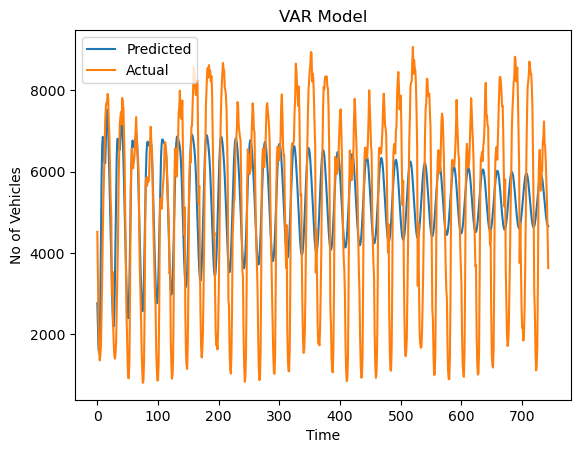

In [32]:
from matplotlib import pyplot as plt
# Plot the predictions and the actual values
plt.plot(y_var[:, 0], label='Predicted')
plt.plot(model_data['No of Vehicles'].values, label='Actual')
plt.title('VAR Model')
plt.xlabel('Time')
plt.ylabel('No of Vehicles')
plt.legend()

In [33]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(model_data['No of Vehicles'].values, y_var[:, 0]))
rmse

1881.3074441691556

# LSTM

In [34]:
scaler = MinMaxScaler(feature_range=(0, 1))

lstm_data_scaled = scaler.fit_transform(lstm_data.values.reshape(-1, 1))

In [35]:
# Create the test data
X_test = []
y_test = []
for i in range(36, len(lstm_data_scaled)):
    X_test.append(lstm_data_scaled[i-36:i, 0])
    y_test.append(lstm_data_scaled[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [36]:
# Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [37]:
# Make predictions
predictions = lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

23/23 [==============================] - 3s 83ms/step


In [38]:
mse = mean_squared_error(np.array(data['No of Vehicles'][36:]), np.array(predictions.reshape(-1)))
rmse = np.sqrt(mse)
rmse

943.9624717150552

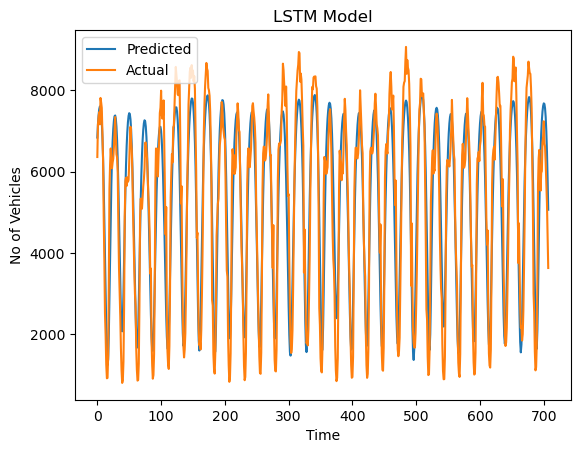

In [39]:
# Plot the predictions and the actual values
plt.plot(predictions, label='Predicted')
plt.plot(data['No of Vehicles'][36:].values, label='Actual')
plt.title('LSTM Model')
plt.xlabel('Time')
plt.ylabel('No of Vehicles')
plt.legend()

# XGBoost Model

In [40]:
# Add lags to the data
for i in range(1,26):
    model_data["lag_{}".format(i)] = model_data['No of Vehicles'].shift(i)
    
# Create train and test set from lagged data
model_data.dropna(inplace=True)
X = model_data.drop(['No of Vehicles'], axis=1)
y = model_data['No of Vehicles']

In [41]:
X.shape, y.shape, model_data.shape

((719, 28), (719,), (719, 29))

In [42]:
pred_xgboost = xgb.predict(X)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_xgboost, y)))

184.42684961027658


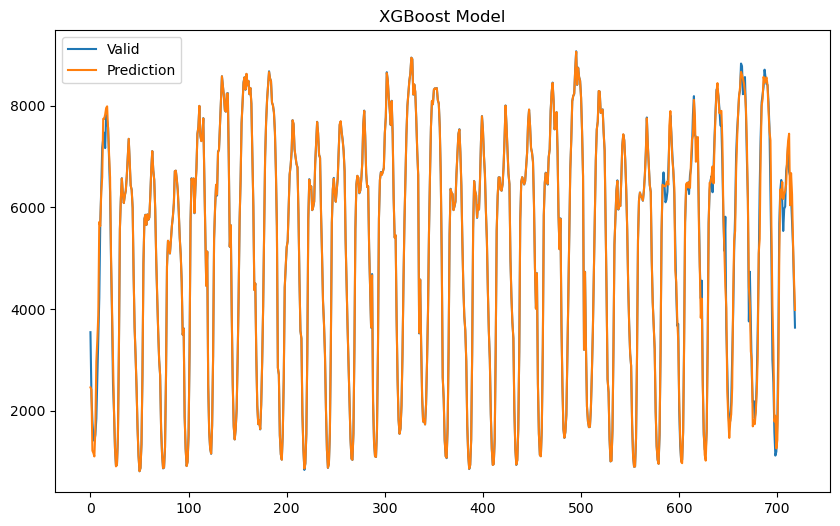

In [43]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y.values, label='Valid')
plt.plot(pred_xgboost, label='Prediction')
plt.legend(loc='best')
plt.title("XGBoost Model")
plt.show()

# Adaboost Model

In [44]:
pred_adaboost = ada.predict(X)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_adaboost, y)))

425.72972363235044


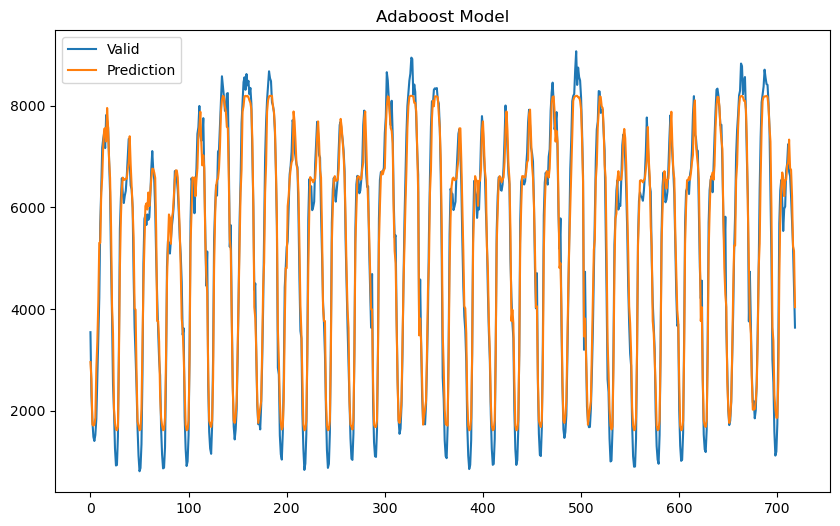

In [45]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y.values, label='Valid')
plt.plot(pred_adaboost, label='Prediction')
plt.legend(loc='best')
plt.title("Adaboost Model")
plt.show()

# Random Forest Model

In [46]:
pred_rf = rf.predict(X)

# Calculate RMSE
print(np.sqrt(mean_squared_error(pred_rf, y)))

214.3728730681903


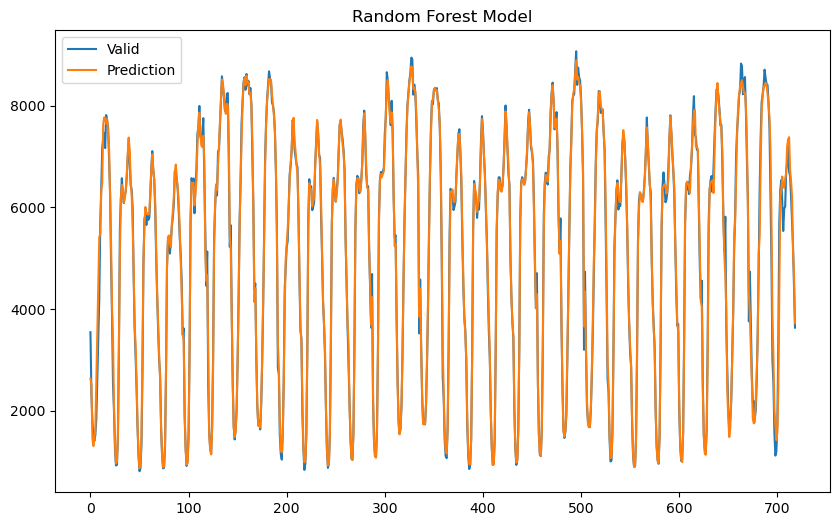

In [47]:
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y.values, label='Valid')
plt.plot(pred_rf, label='Prediction')
plt.legend(loc='best')
plt.title("Random Forest Model")
plt.show()

# Combine Multivariate Models with LSTM

## LSTM + XGBoost

In [49]:
# LSTM used 36 lags - so, data taken = 744-36 = 708
# Multivariates used 25 lags; i.e, 25 data skipped. So, data taken = 744-25 = 719
predictions.shape, pred_xgboost[11:].shape

((708, 1), (708,))

In [50]:
best_value_xgb = 999999
best_weight_xgb = 0

for i in range(1, 100):
    y_pred = (i/100)*predictions.flatten() + (1-i/100)*pred_xgboost[11:]
    rmse = np.sqrt(mean_squared_error(label_data[36:], y_pred))
    print('RMSE for weight %.3f is %.3f' % (i/100, rmse))
    # Save the best weight
    if rmse < best_value_xgb:
        best_value_xgb = rmse
        best_weight_xgb = i/100

RMSE for weight 0.010 is 161.521
RMSE for weight 0.020 is 162.396
RMSE for weight 0.030 is 163.793
RMSE for weight 0.040 is 165.700
RMSE for weight 0.050 is 168.099
RMSE for weight 0.060 is 170.970
RMSE for weight 0.070 is 174.289
RMSE for weight 0.080 is 178.031
RMSE for weight 0.090 is 182.170
RMSE for weight 0.100 is 186.680
RMSE for weight 0.110 is 191.535
RMSE for weight 0.120 is 196.708
RMSE for weight 0.130 is 202.176
RMSE for weight 0.140 is 207.915
RMSE for weight 0.150 is 213.904
RMSE for weight 0.160 is 220.122
RMSE for weight 0.170 is 226.550
RMSE for weight 0.180 is 233.170
RMSE for weight 0.190 is 239.968
RMSE for weight 0.200 is 246.928
RMSE for weight 0.210 is 254.037
RMSE for weight 0.220 is 261.283
RMSE for weight 0.230 is 268.654
RMSE for weight 0.240 is 276.141
RMSE for weight 0.250 is 283.734
RMSE for weight 0.260 is 291.426
RMSE for weight 0.270 is 299.208
RMSE for weight 0.280 is 307.074
RMSE for weight 0.290 is 315.018
RMSE for weight 0.300 is 323.033
RMSE for w

In [51]:
best_value_xgb, best_weight_xgb, (best_weight_xgb*predictions.flatten() + (1-best_weight_xgb)*pred_xgboost[11:]).shape

(161.52106168000094, 0.01, (708,))

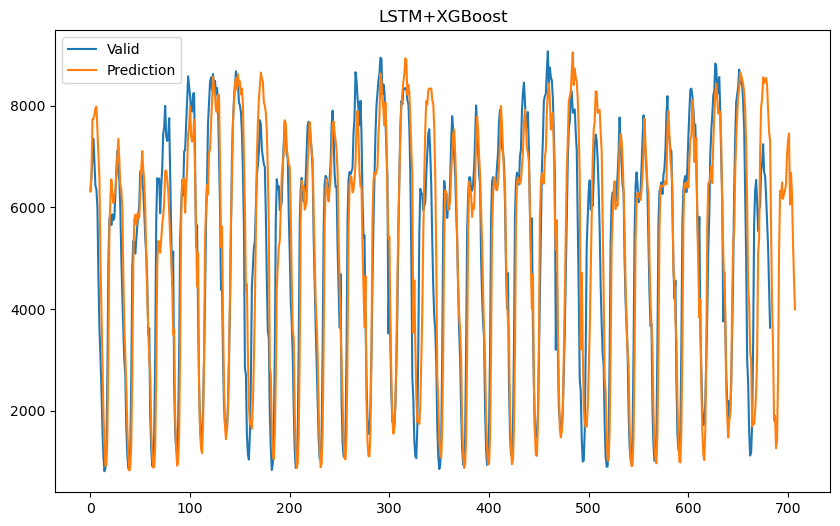

In [52]:
y_pred = best_weight_xgb*predictions.flatten() + (1-best_weight_xgb)*pred_xgboost[11:]
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y[36:].values, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.legend(loc='best')
plt.title("LSTM+XGBoost")
plt.show()

## LSTM + Adaboost

In [53]:
best_value_ada = 999999
best_weight_ada = 0

for i in range(1, 100):
    y_pred = (i/100)*predictions.flatten() + (1-i/100)*pred_adaboost[11:]
    rmse = np.sqrt(mean_squared_error(label_data[36:], y_pred))
    print('RMSE for weight %.3f is %.3f' % (i/100, rmse))
    # Save the best weight
    if rmse < best_value_ada:
        best_value_ada = rmse
        best_weight_ada = i/100

RMSE for weight 0.010 is 424.381
RMSE for weight 0.020 is 426.595
RMSE for weight 0.030 is 428.924
RMSE for weight 0.040 is 431.365
RMSE for weight 0.050 is 433.917
RMSE for weight 0.060 is 436.578
RMSE for weight 0.070 is 439.346
RMSE for weight 0.080 is 442.219
RMSE for weight 0.090 is 445.194
RMSE for weight 0.100 is 448.271
RMSE for weight 0.110 is 451.446
RMSE for weight 0.120 is 454.719
RMSE for weight 0.130 is 458.085
RMSE for weight 0.140 is 461.545
RMSE for weight 0.150 is 465.094
RMSE for weight 0.160 is 468.733
RMSE for weight 0.170 is 472.457
RMSE for weight 0.180 is 476.266
RMSE for weight 0.190 is 480.158
RMSE for weight 0.200 is 484.130
RMSE for weight 0.210 is 488.180
RMSE for weight 0.220 is 492.307
RMSE for weight 0.230 is 496.508
RMSE for weight 0.240 is 500.782
RMSE for weight 0.250 is 505.127
RMSE for weight 0.260 is 509.541
RMSE for weight 0.270 is 514.022
RMSE for weight 0.280 is 518.569
RMSE for weight 0.290 is 523.179
RMSE for weight 0.300 is 527.852
RMSE for w

In [54]:
best_value_ada, best_weight_ada

(424.38129423012424, 0.01)

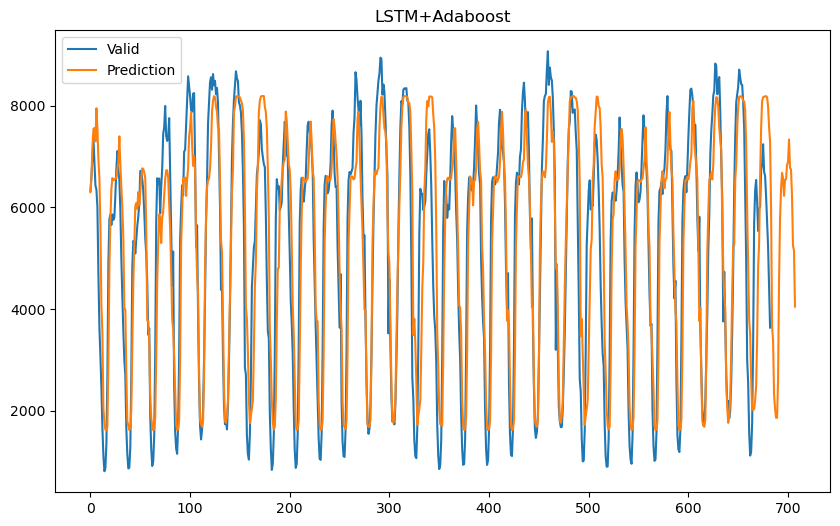

In [55]:
y_pred = best_weight_ada*predictions.flatten() + (1-best_weight_ada)*pred_adaboost[11:]
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y[36:].values, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.legend(loc='best')
plt.title("LSTM+Adaboost")
plt.show()

## LSTM + Random Forest

In [56]:
best_value_rf = 999999
best_weight_rf = 0

for i in range(1, 100):
    y_pred = (i/100)*predictions.flatten() + (1-i/100)*pred_rf[11:]
    rmse = np.sqrt(mean_squared_error(label_data[36:], y_pred))
    print('RMSE for weight %.3f is %.3f' % (i/100, rmse))
    # Save the best weight
    if rmse < best_value_rf:
        best_value_rf = rmse
        best_weight_rf = i/100

RMSE for weight 0.010 is 200.295
RMSE for weight 0.020 is 203.071
RMSE for weight 0.030 is 206.181
RMSE for weight 0.040 is 209.609
RMSE for weight 0.050 is 213.339
RMSE for weight 0.060 is 217.356
RMSE for weight 0.070 is 221.645
RMSE for weight 0.080 is 226.190
RMSE for weight 0.090 is 230.976
RMSE for weight 0.100 is 235.988
RMSE for weight 0.110 is 241.213
RMSE for weight 0.120 is 246.636
RMSE for weight 0.130 is 252.245
RMSE for weight 0.140 is 258.027
RMSE for weight 0.150 is 263.972
RMSE for weight 0.160 is 270.069
RMSE for weight 0.170 is 276.307
RMSE for weight 0.180 is 282.678
RMSE for weight 0.190 is 289.172
RMSE for weight 0.200 is 295.781
RMSE for weight 0.210 is 302.498
RMSE for weight 0.220 is 309.316
RMSE for weight 0.230 is 316.228
RMSE for weight 0.240 is 323.228
RMSE for weight 0.250 is 330.311
RMSE for weight 0.260 is 337.471
RMSE for weight 0.270 is 344.704
RMSE for weight 0.280 is 352.005
RMSE for weight 0.290 is 359.370
RMSE for weight 0.300 is 366.794
RMSE for w

In [57]:
best_value_rf, best_weight_rf

(200.29467728297433, 0.01)

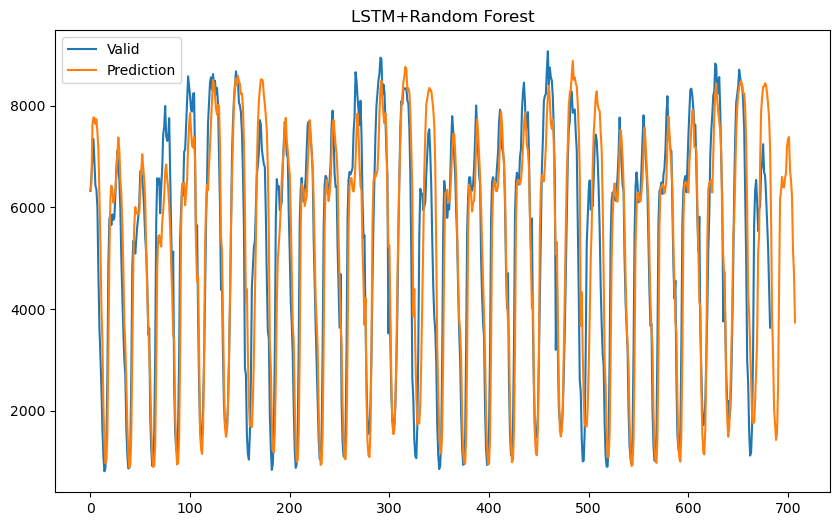

In [58]:
y_pred = best_weight_rf*predictions.flatten() + (1-best_weight_rf)*pred_rf[11:]
# Plotting the results and actual values
plt.figure(figsize=(10,6))
plt.plot(y[36:].values, label='Valid')
plt.plot(y_pred, label='Prediction')
plt.legend(loc='best')
plt.title("LSTM+Random Forest")
plt.show()